## MultiViewAtlas demo

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os,sys
import mudata
import anndata
import scanpy as sc
import pandas as pd
import numpy as np

import multi_view_atlas as mva

Global seed set to 0
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Load fetal-immune dataset

In [2]:
datadir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
h5ad_files = [f for f in os.listdir(datadir) if f.endswith('embedding.h5ad')]
h5ad_files

['PAN.A01.v01.raw_count.20210429.HSC_PROGENITORS.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.LYMPHOID.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.MEM_PROGENITORS.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.STROMA.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.MYELOID_V2.embedding.h5ad',
 'PAN.A01.v01.raw_count.20210429.HSC_IMMUNE.embedding.h5ad']

In [3]:
## Define the hierarchy between views 
view_hierarchy = {'full':{
 'HSC_IMMUNE':{
        'HSC_PROGENITORS':None,
        'LYMPHOID':{
            'NKT':None
        },
        'MYELOID_V2':None,
        'MEM_PROGENITORS':None
    },
    'STROMA':None   
    }
}

In [4]:
# Load full atlas 
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'), backed=True)

In [5]:
# Load each view
adata_dict = {}
adata_dict['full'] = adata_full
for v in mva.utils.get_views_from_structure(view_hierarchy):
    if v != 'full':
        vdata = sc.read_h5ad(os.path.join(datadir, f'PAN.A01.v01.raw_count.20210429.{v}.embedding.h5ad'), backed=True)
        # adata_dict[v] = AnnData(obs=vdata.obs, obsm=vdata.obsm)
        adata_dict[v] = vdata

## Initialize MultiViewAtlas object

A MultiViewAtlas object can be initialized from a `MuData` object, storing the view hierarchy in `.uns`, or from an `AnnData` object of the full dataset, additionally storing an assignment of cells to views in `adata.obsm['view_assign']` (here we don't want to initialize from AnnData because for all the views we already have different dimensionality reductions). 

The `transition_rule` parameter defines which info should be used to subset cells from one parent view to a child view. The transition rule is set to be the same for all transitions during initialization, but it can be updated later.  

In [7]:
# # Initialize from AnnData
# 
# # make table assigning cells to views
# view_assign = pd.DataFrame(index=adata_full.obs_names)
# for v in adata_dict.keys():
#     view_assign[v] = view_assign.index.isin(adata_dict[v].obs_names).astype(int)
# 
# adata_full.uns['view_hierarchy'] = view_hierarchy.copy()
# adata_full.obsm['view_assign'] = view_assign.copy()
# mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='X_scvi')

# Initialize from mudata object
mdata = mudata.MuData(adata_dict)
mdata.obs = mdata['full'].obs.copy() # otherwise obs cols are named full:colname 
mdata['full'].uns['view_hierarchy'] = view_hierarchy.copy()
mvatlas = mva.tl.MultiViewAtlas(mdata, transition_rule=None)

In [22]:
mvatlas.mdata

MuData object with n_obs × n_vars = 911873 × 268304
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
  obsm:	'view_assign'
  11 modalities
    full:	911873 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'leiden', 'scvi', 'umap', 'view_hierarchy', 'view_color_colors'
      obsm:	'X_scvi_full', 'X_umap_full', 'view_assign_full'
      obsp:	'scvi_connectivities', 'scvi_distances'
    HSC_IMMUNE:	593203 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      uns:	'view_color_colors'
      obsm:	'X_scvi_HSC_IMMUNE', 'X_umap_HSC_IMMUNE'
    HSC_PROGENITORS:	40422 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_HSC_PROGENITORS', 'X_umap_HSC_PROGENITORS'
    LYMPHOID:	241950 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      uns:	'view_color_colors'
      obsm:	'X_scvi_LYMPHOID', 'X_umap_LYMPHOID'
    NKT:	174261 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      uns:	'anno_lvl_2_final_clean_colors'
      obsm:	'X_scvi_NKT', 'X_umap_NKT'
    MYELOID_V2:	218758 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_MYELOID_V2', 'X_umap_MYELOID_V2'
    MEM_PROGENITORS:	149239 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_MEM_PROGENITORS', 'X_umap_MEM_PROGENITORS'
    STROMA:	318670 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      uns:	'view_color_colors'
      obsm:	'X_scvi_STROMA', 'X_umap_STROMA', 'X_umap_full'
    hematopoietic_tissue:	38505 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      obsm:	'X_scvi_full', 'X_umap_full', 'view_assign_full'
      obsp

The `MultiViewAtlas` object stores a MuData object where modalities are different subsets (views) of the full dataset. The full gene expression matrix is stored only in the `full` view, while for all other views we store latent dimensions in `.obsm` and metadata in `.obs` only. We can attach gene expression values to a single view when needed accessing directly from the MultiViewAtlas object.

In [ ]:
mvatlas.mdata['HSC_IMMUNE'] # No gene expression matrix in .X
mvatlas['HSC_IMMUNE'] # With gene expression matrix in .X

The hierarchy between views is stored in `mvatlas.view_hierarchy`

In [9]:
mvatlas.view_hierarchy

{'full': {'HSC_IMMUNE': {'HSC_PROGENITORS': None,
   'LYMPHOID': {'NKT': None},
   'MYELOID_V2': None,
   'MEM_PROGENITORS': None},
  'STROMA': None}}

The information used to transition from one parent view to a child view is stored in `mvatlas.view_transition_rule`. The transition rule can be a latent space (a slot in `.obsm`) or cell-level metadata (a column in `.obs`). If the transition rule is a latent space, cells in one view are assigned to the next view by similarity in that latent space. If the transition rule is cell-level metadata, cells in one view are assigned to the next view based on labels for that column in obs.

In [10]:
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NKT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can set different rules for different transitions. For example we can set the split from Lymphoid to NKT view to be based on annotation labels, rather than position in the latent space (__N.B. for now I haven't implemented any check that the rule is followed, if the atlas is already initialized!__)

In [11]:
mvatlas.set_transition_rule(parent_view='LYMPHOID', child_view='NKT', transition_rule='anno_lvl_2_final_clean')
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN
NKT,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualize multi-view structure

The `multiview_embedding` plot shows the embedding of cells in a view and highlighting those cells in all the parent views.

In [28]:
basis_from_full = False
v = 'full'
basis='X_umap'
legend_loc_pl = 'right_margin'
if basis_from_full:
    if f"{basis}_full" in mdata["full"].obsm.keys():
        pl_basis = f"{basis}_full"
    elif basis in mdata["full"].obsm.keys():
        pl_basis = basis
    else:
        raise ValueError(f"Embedding {basis} not in mdata['full'].obsm")
    mdata.mod[v].obsm[pl_basis] = mdata.mod["full"][mdata.mod[v].obs_names].obsm[basis]
else:
    pl_basis = f"{basis}_{v}"

# sc.pl.embedding(
#           mdata[v],
#           basis=pl_basis,
#           title=f"{v} view",
#           color="view_color"
#       )

mdata

MuData object with n_obs × n_vars = 911873 × 268304
  obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
  obsm:	'view_assign'
  8 modalities
    full:	911873 x 33538
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
      var:	'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
      uns:	'leiden', 'scvi', 'umap', 'view_hierarchy'
      obsm:	'X_scvi_full_full', 'X_umap_full_full', 'view_assign_full_full', 'view_assign_full'
      obsp:	'scvi_connectivities', 'scvi_distances'
    HSC_IMMUNE:	593203 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_HSC_IMMUNE', 'X_umap_HSC_IMMUNE'
    HSC_PROGENITORS:	40422 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_HSC_PROGENITORS', 'X_umap_HSC_PROGENITORS'
    LYMPHOID:	241950 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_LYMPHOID', 'X_umap_LYMPHOID'
    NKT:	174261 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_NKT', 'X_umap_NKT'
    MYELOID_V2:	218758 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_MYELOID_V2', 'X_umap_MYELOID_V2'
    MEM_PROGENITORS:	149239 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_MEM_PROGENITORS', 'X_umap_MEM_PROGENITORS'
    STROMA:	318670 x 0
      obs:	'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
      obsm:	'X_scvi_STROMA', 'X_umap_STROMA'

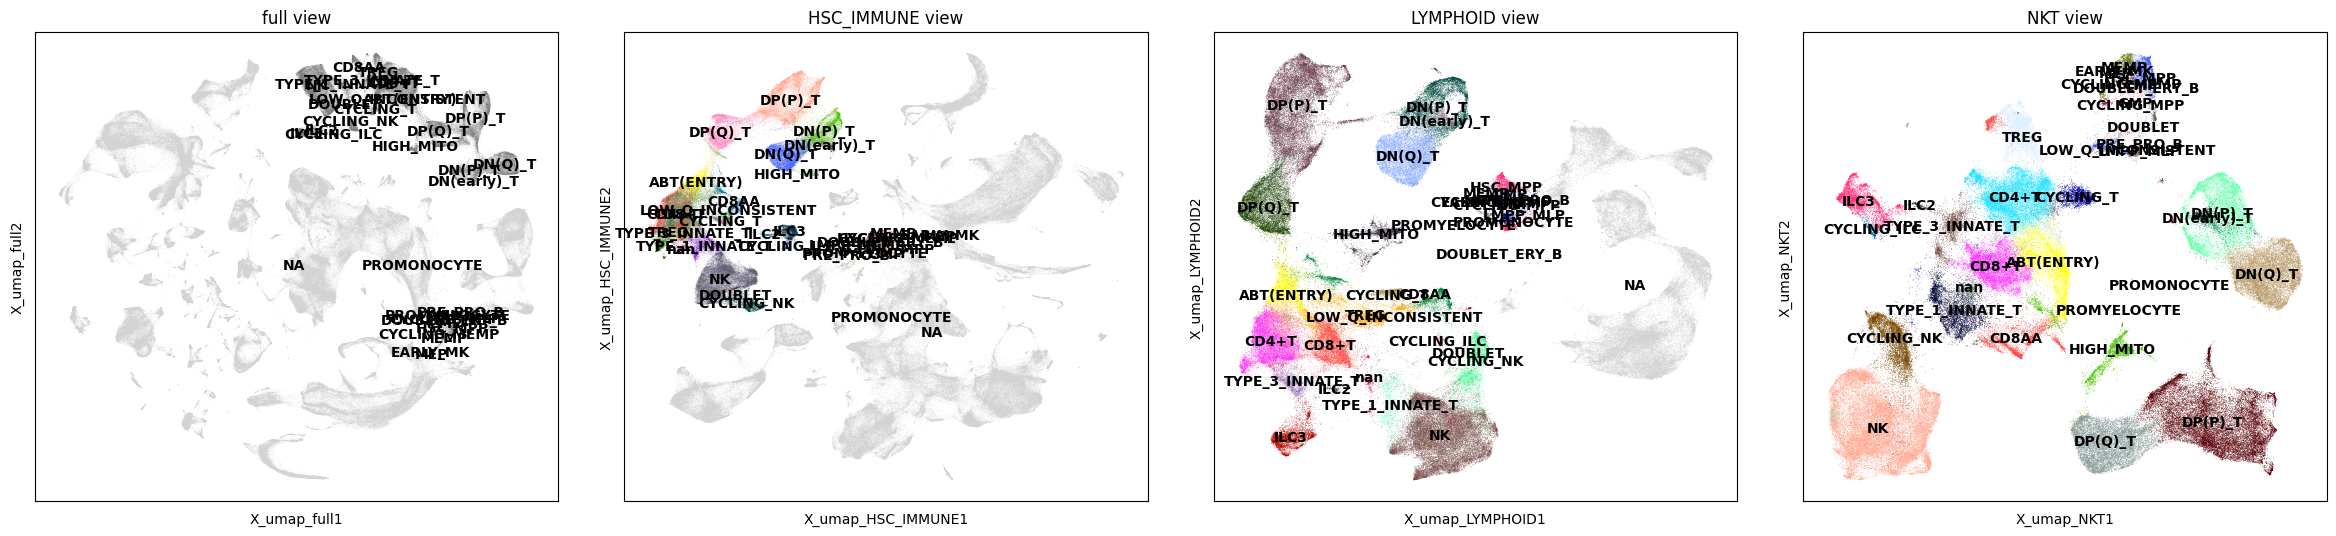

In [12]:
mva.pl.multiview_embedding(mvatlas.mdata, view='NKT', color='anno_lvl_2_final_clean')


## Add new views to atlas 

We can add new splits to a MultiViewAtlas object as we go, making a new assignment table. For example, we might want to split the stromal compartment by organ classes.

In [13]:
assign_dict = {
    'hematopoietic_tissue':['BM', "LI", "YS"],
    'lymphoid_tissue':['TH', "MLN", "SP"],
    'peripheral_tissue':['SK', "GU", 'KI']
}

transition_rule = 'organ'
parent_view = 'STROMA'

assign_tab = np.vstack([np.where(mvatlas.mdata[parent_view].obs[transition_rule].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = mvatlas.mdata[parent_view].obs_names)

In [14]:
assign_tab.head()

,hematopoietic_tissue,lymphoid_tissue,peripheral_tissue
index,,,
FCAImmP7579224-GGGTTGCAGAAGGGTA,0,0,1
FCAImmP7579224-GACTGCGTCTTGGGTA,0,0,1
FCAImmP7579224-ATCATGGTCAAGAAGT,0,0,1
FCAImmP7579224-ACGGCCACACAACTGT,0,0,1
FCAImmP7579224-GAAACTCAGGCTCATT,0,0,1


In [15]:
mvatlas.update_views(parent_view='STROMA', child_assign_tab=assign_tab, transition_rule=transition_rule)

In [16]:
mvatlas.mdata['hematopoietic_tissue']

AnnData object with n_obs × n_vars = 38505 × 0
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'view_color'
    obsm: 'X_scvi_full', 'X_umap_full', 'view_assign_full'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [17]:
mvatlas.view_transition_rule

,full,HSC_IMMUNE,HSC_PROGENITORS,LYMPHOID,NKT,MYELOID_V2,MEM_PROGENITORS,STROMA,hematopoietic_tissue,lymphoid_tissue,peripheral_tissue
full,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_IMMUNE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSC_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LYMPHOID,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN,NaN,NaN,NaN
NKT,NaN,NaN,NaN,anno_lvl_2_final_clean,anno_lvl_2_final_clean,NaN,NaN,NaN,NaN,NaN,NaN
MYELOID_V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEM_PROGENITORS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STROMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,organ,organ,organ
hematopoietic_tissue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,organ,NaN,NaN
lymphoid_tissue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organ,NaN,organ,NaN


In [18]:
mvatlas.mdata['lymphoid_tissue'].obs['organ'].value_counts()


SP     46754
TH     12801
MLN      623
Name: organ, dtype: int64

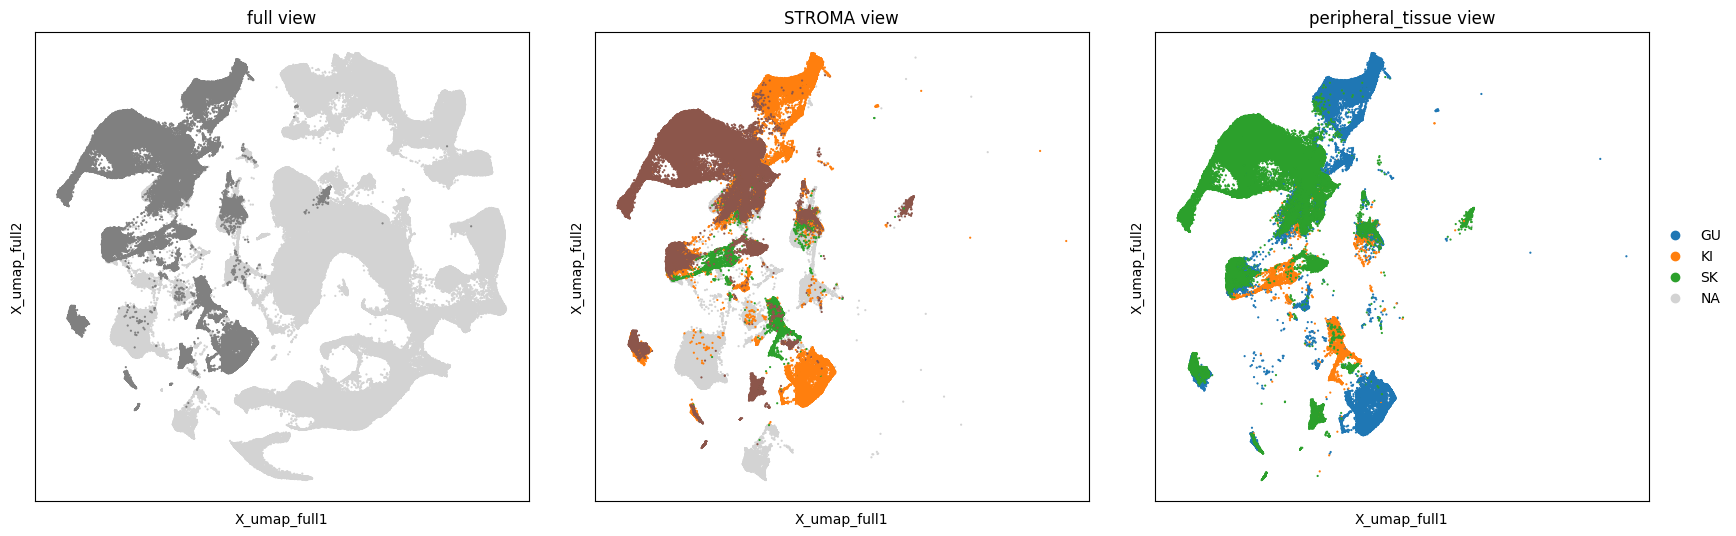

In [21]:
mva.pl.multiview_embedding(mvatlas.mdata, view='peripheral_tissue', 
                           color='organ', basis_from_full=True, basis='X_umap_full',
                           legend_loc='right margin', size=10)

---
---

## Update atlas object with query cells - mini demo

Make demo MultiViewAtlas object

In [91]:
adata_full = sc.read_h5ad(os.path.join(datadir, 'PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'), backed=False)
sc.pp.subsample(adata_full, 0.50, copy=False)

## Split in reference and query
query_cells = np.random.choice(adata_full.obs_names, size=int(np.round(adata_full.n_obs*0.1)), replace=False)
adata_query = adata_full[query_cells].copy()
adata_full = adata_full[~adata_full.obs_names.isin(query_cells)].copy()

### Split by organ
assign_dict = {
    'hematopoietic_tissue':['BM', "LI", "YS"],
    'lymphoid_tissue':['TH', "MLN", "SP"],
    'peripheral_tissue':['SK', "GU", 'KI']
}
annotation_col = 'organ'

assign_tab = np.vstack([np.where(adata_full.obs[annotation_col].isin(assign_dict[k]), 1, 0) for k in assign_dict.keys()]).T
assign_tab = pd.DataFrame(assign_tab, columns = assign_dict.keys(), index = adata_full.obs_names)

## Make dictionary of parent-child structure of views
view_hierarchy = { 'full':{
    'lymphoid_tissue':None,
    'hematopoietic_tissue':None,
    'peripheral_tissue':None
    }
}

adata_full.obsm['view_assign'] = assign_tab.copy()
adata_full.uns['view_hierarchy'] = view_hierarchy.copy()
mvatlas = mva.tl.MultiViewAtlas(adata_full, transition_rule='organ') 

### Split by age in hematopoietic tissue
transition_rule = 'age'
parent_view = 'hematopoietic_tissue'

assign_tab = np.vstack([
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] < 10, 1, 0),
    np.where(mvatlas.mdata[parent_view].obs[transition_rule] >= 10, 1, 0)
    ]).T
assign_tab = pd.DataFrame(
    assign_tab, 
    columns = ['first_trimester', 'second_trimester'], 
    index = mvatlas.mdata[parent_view].obs_names)

mvatlas.update_views(parent_view=parent_view, child_assign_tab=assign_tab, transition_rule=transition_rule)

In [92]:
mvatlas.view_hierarchy

{'full': {'lymphoid_tissue': None,
  'hematopoietic_tissue': {'first_trimester': None, 'second_trimester': None},
  'peripheral_tissue': None}}

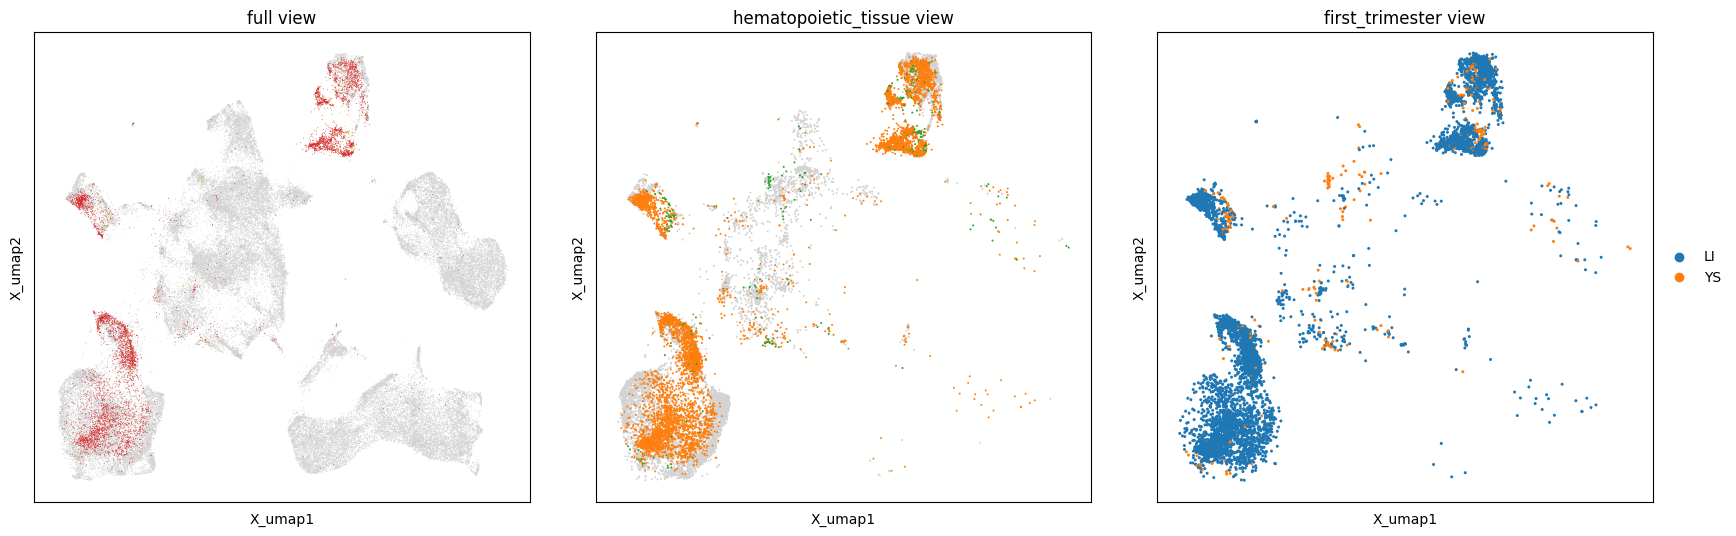

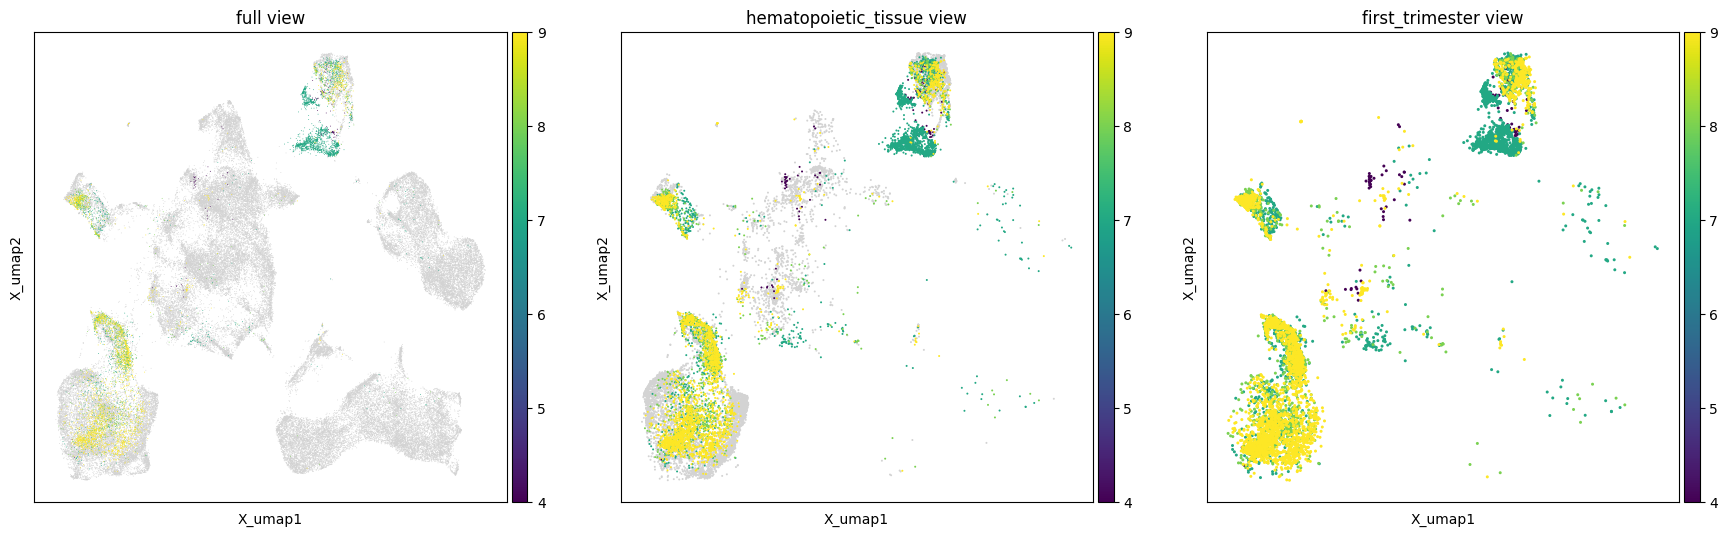

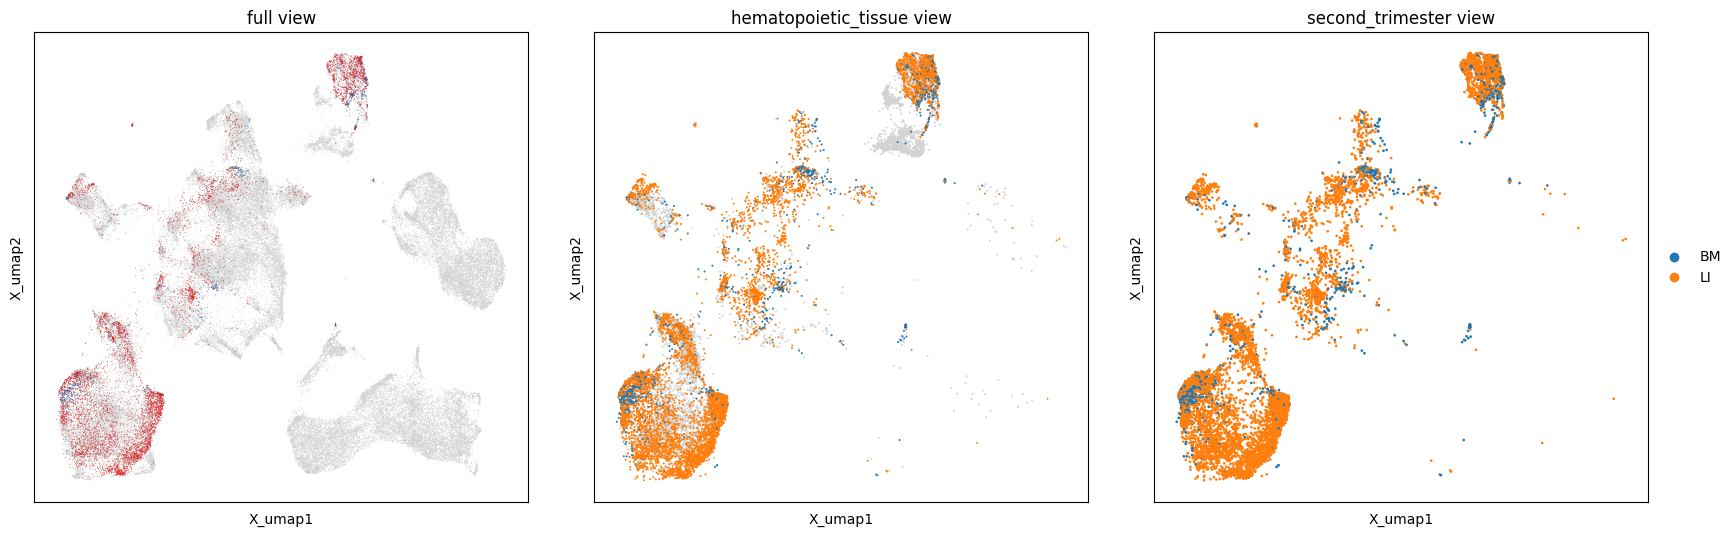

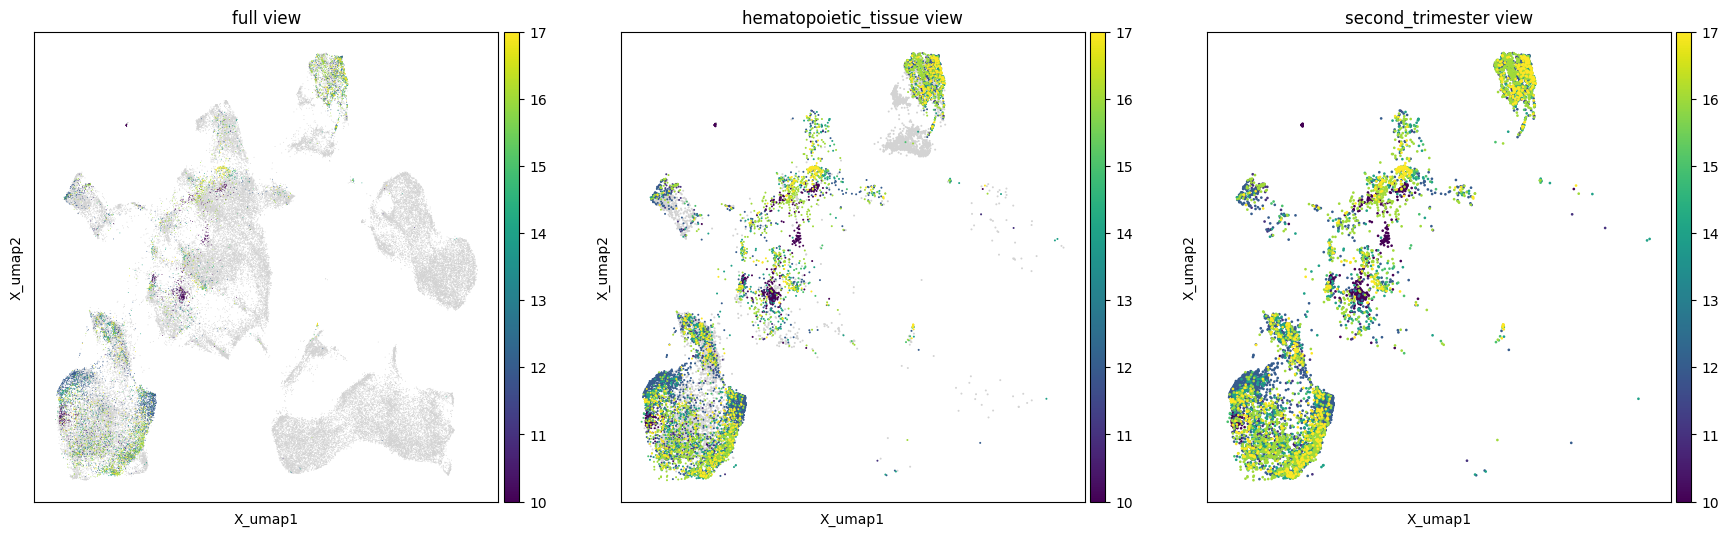

In [93]:
mva.pl.multiview_embedding(mvatlas.mdata, view='first_trimester', color='organ', legend_loc='right margin')
mva.pl.multiview_embedding(mvatlas.mdata, view='first_trimester', color='age')

mva.pl.multiview_embedding(mvatlas.mdata, view='second_trimester', color='organ', legend_loc='right margin')
mva.pl.multiview_embedding(mvatlas.mdata, view='second_trimester', color='age')

We can map query cells to the different atlas views using the transition rules (based on metadata in this case)

In [94]:
mvatlas_mapped = mva.tl.add_query(mvatlas, adata_query)


Assigning to lymphoid_tissue from full
Transition rule: organ
Assigning to hematopoietic_tissue from full
Transition rule: organ
Assigning to peripheral_tissue from full
Transition rule: organ
Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


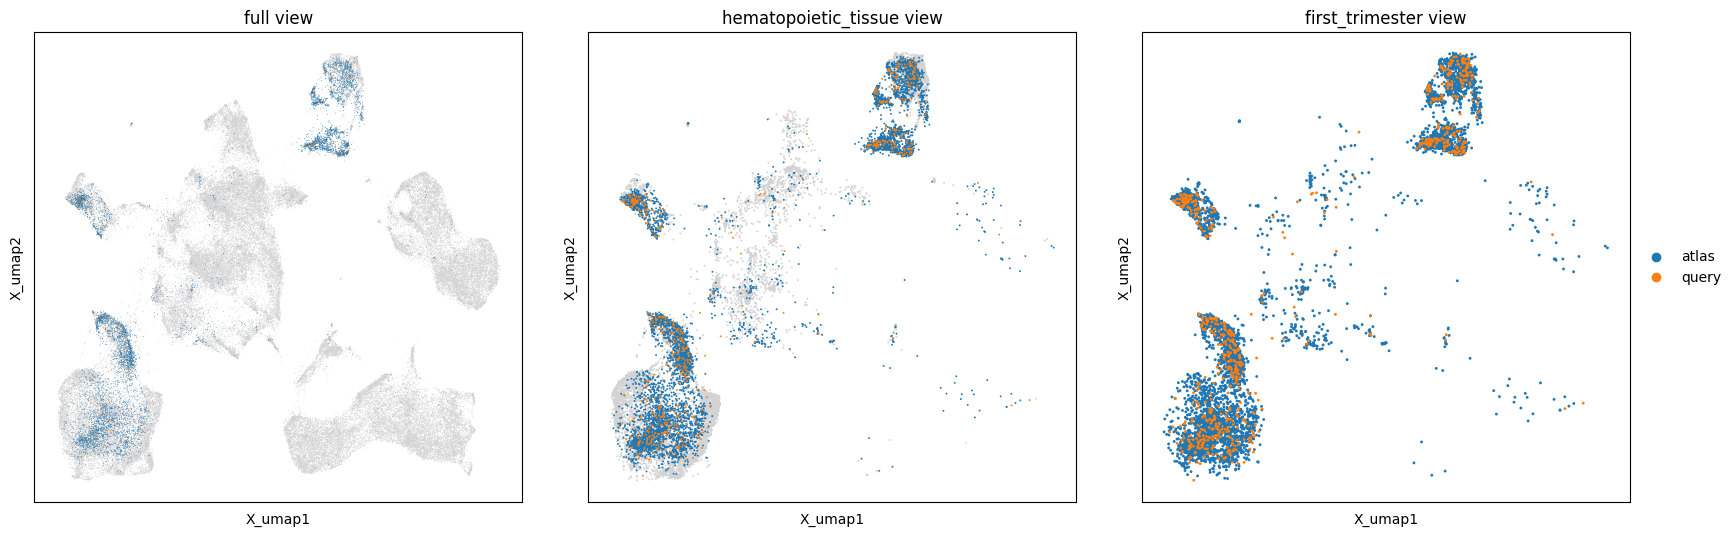

In [95]:
mva.pl.multiview_embedding(mvatlas_mapped, view='first_trimester', color='dataset_group', legend_loc='right margin')

Query data can also be mapped in consecutive steps. For example, if you don't have the age information to to the split.

In [96]:
## Map first depth level (by organ), remove age information to do the second split 
if 'age' in adata_query.obs:
    age_obs = adata_query.obs['age'].copy()
    adata_query.obs.drop('age', 1, inplace=True)
mvatlas_mapped = mva.tl.add_query(mvatlas, adata_query)



Assigning to lymphoid_tissue from full
Transition rule: organ
Assigning to hematopoietic_tissue from full
Transition rule: organ
Assigning to peripheral_tissue from full
Transition rule: organ


Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


In [97]:
mvatlas_mapped.mdata['first_trimester']

AnnData object with n_obs × n_vars = 6435 × 0
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    obsm: 'X_scvi', 'X_umap', 'view_assign'

In [98]:
## Add Age info to query data
if 'age' not in adata_query.obs:
    adata_query.obs['age'] = age_obs.astype(np.float64).copy()
mvatlas_mapped_2 = mva.tl.add_query(mvatlas_mapped, adata_query)

Assigning to first_trimester from hematopoietic_tissue
Transition rule: age
Assigning to second_trimester from hematopoietic_tissue
Transition rule: age


In [99]:
mvatlas_mapped_2.mdata['first_trimester']


AnnData object with n_obs × n_vars = 7135 × 0
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'dataset_group'
    obsm: 'X_scvi', 'X_umap'

At the moment if mapping the first depth level fails it still tries to map the next levels and throws an error  

In [20]:
## Map first depth level (by organ), remove age information to do the second split 
if 'organ' in adata_query.obs:
    organ_obs = adata_query.obs['organ'].copy()
    adata_query.obs.drop('organ', 1, inplace=True)
mvatlas_mapped = mva.tl.add_query(mvatlas, adata_query)

Assigning to lymphoid_tissue from full


Transition rule: organ
Assigning to hematopoietic_tissue from full


Transition rule: organ
Assigning to peripheral_tissue from full


Transition rule: organ
Assigning to first_trimester from hematopoietic_tissue
Transition rule: age


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KNeighborsClassifier.